#Required Imports

##Basic Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt
import sklearn
from tqdm import tqdm

##Data Preprocessing

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

##Models

In [3]:
pip install scikeras

In [4]:
#ML Models
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

#Neural Net
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback
from scikeras.wrappers import KerasClassifier

##Metrics and Helpers

In [5]:
#Metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score,fbeta_score
from sklearn.metrics import roc_auc_score, accuracy_score

#Helpers
from scipy.stats import mode
from sklearn.model_selection import GridSearchCV
from collections import Counter

Set random state of pipeline

In [6]:
rs=40

# Data Loading



Loading train data

In [7]:
train_df = pd.read_csv("/content/train_dataset_final1.csv")
train_df.rename(columns={'pay_0': 'pay_1'}, inplace=True)

Loading test data

In [8]:
test_df = pd.read_csv("/content/validate_dataset_final.csv")
test_df.rename(columns={'pay_0': 'pay_1'}, inplace=True)

Finding and cleaning NaN values(by filling with median values of columns)

In [9]:
train_df.columns[train_df.isnull().any()], test_df.columns[test_df.isnull().any()]

(Index(['age'], dtype='object'), Index([], dtype='object'))

In [10]:
train_df.fillna(train_df.median(), inplace=True)

# Exploratory Data Analysis

##sex vs default

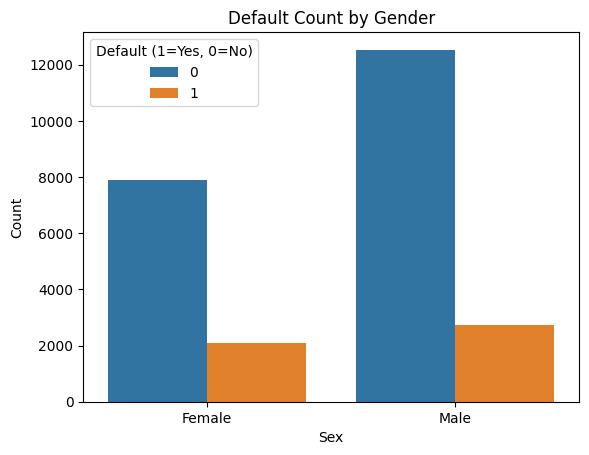

In [11]:
plot_df = train_df.assign(sex=train_df['sex'].map({1: 'Male', 0: 'Female'}))
plot_df['next_month_default'] = train_df['next_month_default']  # Add target column to same df

# Plot
sbn.countplot(data=plot_df, x='sex', hue='next_month_default')
plt.title("Default Count by Gender")
plt.xlabel("Sex")
plt.ylabel("Count")
plt.legend(title="Default (1=Yes, 0=No)")
plt.show()

##age vs default

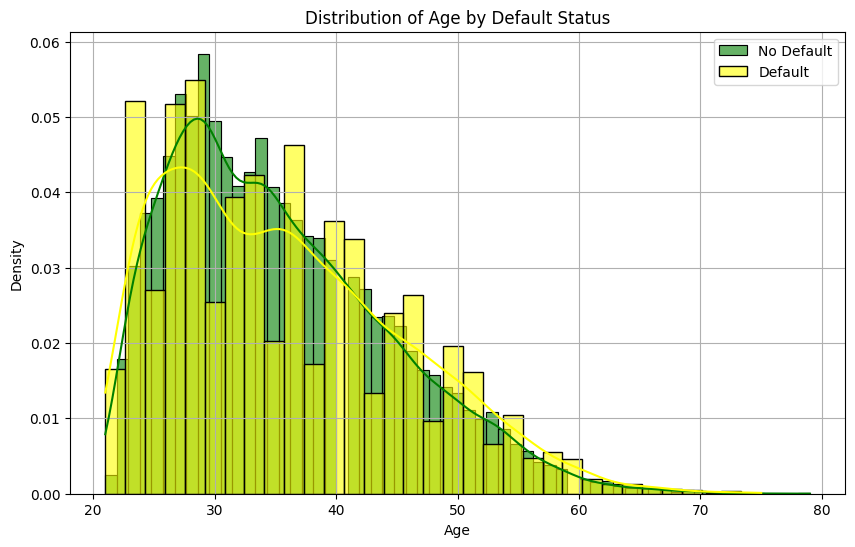

In [12]:
plt.figure(figsize=(10, 6))

# Distribution for Non-Defaulters
sbn.histplot(train_df[train_df['next_month_default'] == 0]['age'],
             kde=True, color='green', label='No Default', stat='density', alpha=0.6)

# Distribution for Defaulters
sbn.histplot(train_df[train_df['next_month_default'] == 1]['age'],
             kde=True, color='yellow', label='Default', stat='density', alpha=0.6)

# Plot settings
plt.title('Distribution of Age by Default Status')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


##Split Violin Plot of Limit Balance by Default Status and Sex

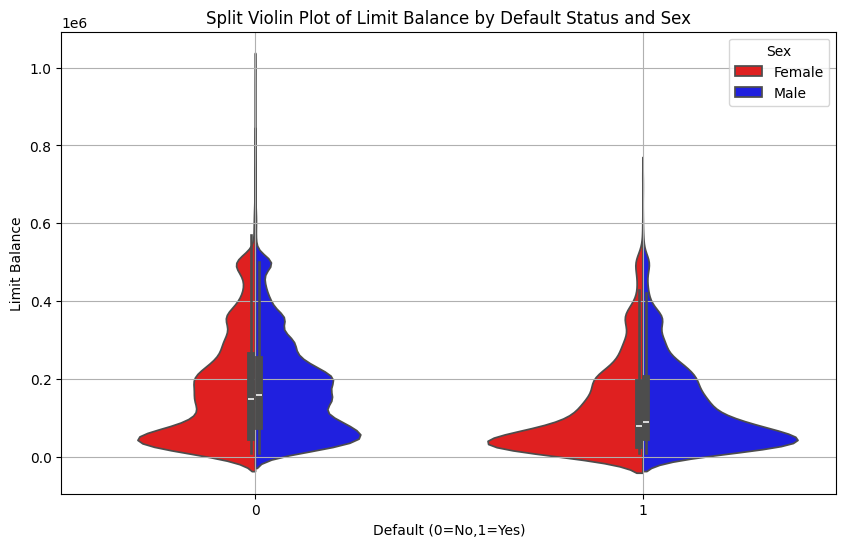

In [13]:
plot_df = train_df.copy()
plot_df['sex'] = plot_df['sex'].map({0: 'Female', 1: 'Male'})

plt.figure(figsize=(10, 6))
sbn.violinplot(
    data=plot_df,
    x="next_month_default",
    y="LIMIT_BAL",
    hue="sex",
    split=True,
    palette={"Male": "blue", "Female": "red"}
)

plt.title("Split Violin Plot of Limit Balance by Default Status and Sex")
plt.xlabel("Default (0=No,1=Yes)")
plt.ylabel("Limit Balance")
plt.legend(title="Sex")
plt.grid(True)
plt.show()


##Payment Delays

<ipython-input-14-2391177991>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sbn.barplot(x=x_vals, y=y_vals, palette='flare')


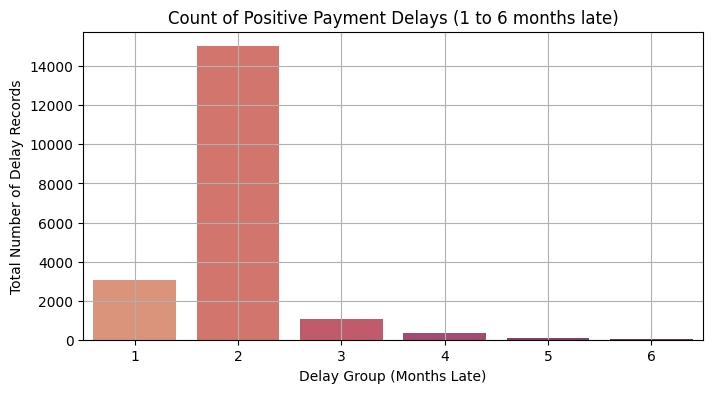

In [14]:
pay_cols = [f'pay_{i}' for i in [1, 2, 3, 4, 5, 6]]

delay_counter = Counter()
for col in pay_cols:
    col_counts = train_df[col].value_counts()
    for delay_val in range(1, 7):  # Only 1 to 6
        delay_counter[delay_val] += col_counts.get(delay_val, 0)

x_vals = list(range(1, 7))
y_vals = [delay_counter[d] for d in x_vals]

plt.figure(figsize=(8, 4))
sbn.barplot(x=x_vals, y=y_vals, palette='flare')
plt.title('Count of Positive Payment Delays (1 to 6 months late)')
plt.xlabel('Delay Group (Months Late)')
plt.ylabel('Total Number of Delay Records')
plt.grid(True)
plt.show()


##repayment consistency

<ipython-input-15-3312492025>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sbn.barplot(


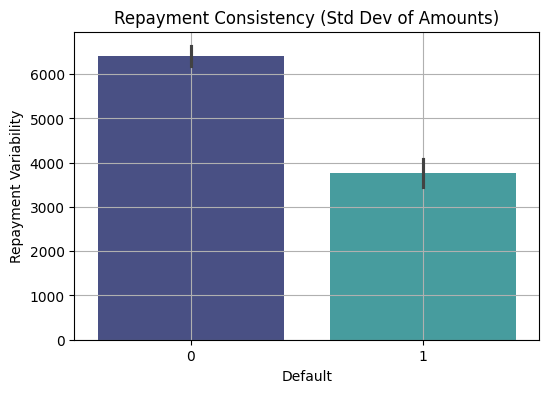

In [15]:
repay_cols = [f'pay_amt{i}' for i in range(1, 7)]

plt.figure(figsize=(6, 4))
sbn.barplot(
    x=train_df['next_month_default'],
    y=train_df[repay_cols].std(axis=1),
    palette='mako'
)
plt.title('Repayment Consistency (Std Dev of Amounts)')
plt.xlabel('Default')
plt.ylabel('Repayment Variability')
plt.grid(True)
plt.show()

##Highly co-related features(corr>.9)

In [16]:
corr_matrix = train_df.corr()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

threshold = 0.9
high_corr_pairs = [
    (col, row, upper.loc[row, col])
    for col in upper.columns
    for row in upper.index
    if(upper.loc[row, col]) > threshold
]

print(f"Highly Correlated Feature Pairs (|corr| > {threshold}):")
for col1, col2, corr_val in high_corr_pairs:
    print(f"{col1} ↔ {col2}  =>  Correlation: {corr_val:.2f}")

Highly Correlated Feature Pairs (|corr| > 0.9):
Bill_amt2 ↔ Bill_amt1  =>  Correlation: 0.95
Bill_amt3 ↔ Bill_amt2  =>  Correlation: 0.93
Bill_amt4 ↔ Bill_amt3  =>  Correlation: 0.92
Bill_amt5 ↔ Bill_amt4  =>  Correlation: 0.94
Bill_amt6 ↔ Bill_amt4  =>  Correlation: 0.90
Bill_amt6 ↔ Bill_amt5  =>  Correlation: 0.95
AVG_Bill_amt ↔ Bill_amt1  =>  Correlation: 0.94
AVG_Bill_amt ↔ Bill_amt2  =>  Correlation: 0.96
AVG_Bill_amt ↔ Bill_amt3  =>  Correlation: 0.96
AVG_Bill_amt ↔ Bill_amt4  =>  Correlation: 0.97
AVG_Bill_amt ↔ Bill_amt5  =>  Correlation: 0.95
AVG_Bill_amt ↔ Bill_amt6  =>  Correlation: 0.93


#Feature Engineering

##credit utilization

In [17]:
train_df['credit_utilization'] = train_df[[f'Bill_amt{i}' for i in range(1, 7)]].mean(axis=1) / (train_df['LIMIT_BAL'] + 1)
test_df['credit_utilization'] = test_df[[f'Bill_amt{i}' for i in range(1, 7)]].mean(axis=1) / (test_df['LIMIT_BAL'] + 1)

##max and avg delay

In [18]:
pay_cols = ['pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']

train_df['max_delay'] = train_df[pay_cols].max(axis=1)
train_df['avg_delay'] = train_df[pay_cols].mean(axis=1)

test_df['max_delay'] = test_df[pay_cols].max(axis=1)
test_df['avg_delay'] = test_df[pay_cols].mean(axis=1)

##delinquency streaks

In [19]:
def max_delinquency_streak(row):
    streak = max_streak = 0
    for val in row:
        if val > 0:
            streak += 1
            max_streak = max(max_streak, streak)
        else:
            streak = 0
    return max_streak

pay_cols = [f'pay_{i}' for i in [1, 2, 3, 4, 5, 6]]

# Longest continuous delinquency
train_df['max_delinquency_streak'] = train_df[pay_cols].apply(max_delinquency_streak, axis=1)
test_df['max_delinquency_streak'] = test_df[pay_cols].apply(max_delinquency_streak, axis=1)

# Total delinquent months
train_df['total_delinquent_months'] = (train_df[pay_cols] > 0).sum(axis=1)
test_df['total_delinquent_months'] = (test_df[pay_cols] > 0).sum(axis=1)

<ipython-input-20-492501368>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sbn.barplot(data=train_df, x='next_month_default', y='max_delinquency_streak', palette='magma')


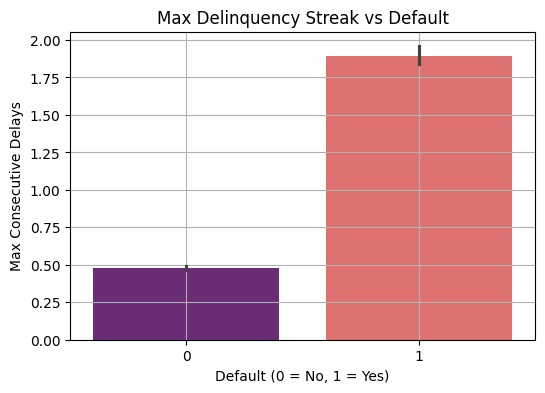

In [20]:
plt.figure(figsize=(6, 4))
sbn.barplot(data=train_df, x='next_month_default', y='max_delinquency_streak', palette='magma')
plt.title('Max Delinquency Streak vs Default')
plt.xlabel('Default (0 = No, 1 = Yes)')
plt.ylabel('Max Consecutive Delays')
plt.grid(True)
plt.show()

<ipython-input-21-1231327201>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sbn.barplot(data=train_df, x='next_month_default', y='total_delinquent_months', palette='coolwarm')


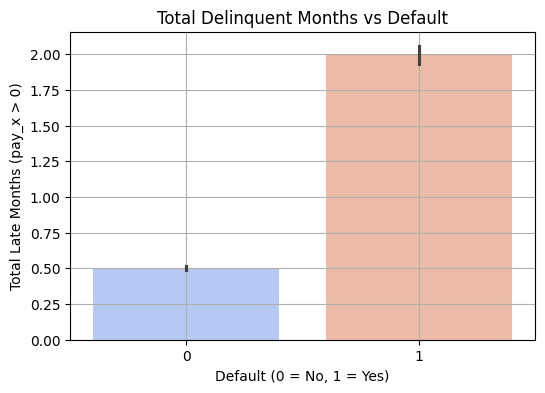

In [21]:
plt.figure(figsize=(6, 4))
sbn.barplot(data=train_df, x='next_month_default', y='total_delinquent_months', palette='coolwarm')
plt.title('Total Delinquent Months vs Default')
plt.xlabel('Default (0 = No, 1 = Yes)')
plt.ylabel('Total Late Months (pay_x > 0)')
plt.grid(True)
plt.show()

#Data Preprocessing

##removing Bill_amt cols(they are highly correlated with avg_bill_amt

In [22]:
drop_cols = [f'Bill_amt{i}' for i in range(1, 7)]

train_df.drop(columns=drop_cols, inplace=True)
test_df.drop(columns=drop_cols, inplace=True)

##preparing train and test data

In [23]:
target_col = 'next_month_default'
id_col = 'Customer_ID'

X = train_df.drop([target_col, id_col], axis=1)
y = train_df[target_col]

test_X = test_df.drop(columns=[id_col])

##data scaling

In [24]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
test_X = scaler.transform(test_X)

##data balancing using SMOTE (Synthetic Minority Oversampling Technique)

In [25]:
sm = SMOTE(random_state=rs)
X, y = sm.fit_resample(X, y)

##splitting train data into train-val(80-20)

In [26]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=rs)

#Training and Evaluating Models

##Logistic Regression

In [27]:
# Fit Logistic Regression
logreg_model = LogisticRegression(max_iter=1000, random_state=rs)
logreg_model.fit(X_train, y_train)

# Predict on validation data
logreg_preds = logreg_model.predict(X_val)
logreg_probs = logreg_model.predict_proba(X_val)[:, 1]

# Evaluate
print("📘 Logistic Regression Evaluation:")
print(f"🔹 Accuracy:  {accuracy_score(y_val, logreg_preds):.4f}")
print(f"🔹 Precision: {precision_score(y_val, logreg_preds):.4f}")
print(f"🔹 F1 Score:  {f1_score(y_val, logreg_preds):.4f}")
print(f"🔹 F2 Score:  {fbeta_score(y_val, logreg_preds, beta=2):.4f}")
print(f"🔹 AUC-ROC:   {roc_auc_score(y_val, logreg_probs):.4f}")


📘 Logistic Regression Evaluation:
🔹 Accuracy:  0.7032
🔹 Precision: 0.7621
🔹 F1 Score:  0.6805
🔹 F2 Score:  0.6395
🔹 AUC-ROC:   0.7673


On whole train data

In [28]:
#Predict
logreg_preds = logreg_model.predict(X)
logreg_probs = logreg_model.predict_proba(X)[:, 1]

# Evaluate
print("📘 Logistic Regression Evaluation:")
print(f"🔹 Accuracy:  {accuracy_score(y, logreg_preds):.4f}")
print(f"🔹 Precision: {precision_score(y, logreg_preds):.4f}")
print(f"🔹 F1 Score:  {f1_score(y, logreg_preds):.4f}")
print(f"🔹 F2 Score:  {fbeta_score(y, logreg_preds, beta=2):.4f}")
print(f"🔹 AUC-ROC:   {roc_auc_score(y, logreg_probs):.4f}")

📘 Logistic Regression Evaluation:
🔹 Accuracy:  0.7008
🔹 Precision: 0.7471
🔹 F1 Score:  0.6698
🔹 F2 Score:  0.6307
🔹 AUC-ROC:   0.7588


##Decision Trees

In [29]:
# Fit Decision Tree
tree_model = DecisionTreeClassifier(max_depth=12, random_state=rs)
tree_model.fit(X_train, y_train)

# Predict on validation data
tree_preds = tree_model.predict(X_val)
tree_probs = tree_model.predict_proba(X_val)[:, 1]

# Evaluate
print("\n📘 Decision Tree Evaluation:")
print(f"🔹 Accuracy:  {accuracy_score(y_val, tree_preds):.4f}")
print(f"🔹 Precision: {precision_score(y_val, tree_preds):.4f}")
print(f"🔹 F1 Score:  {f1_score(y_val, tree_preds):.4f}")
print(f"🔹 F2 Score:  {fbeta_score(y_val, tree_preds, beta=2):.4f}")
print(f"🔹 AUC-ROC:   {roc_auc_score(y_val, tree_probs):.4f}")


📘 Decision Tree Evaluation:
🔹 Accuracy:  0.7873
🔹 Precision: 0.8058
🔹 F1 Score:  0.7889
🔹 F2 Score:  0.7791
🔹 AUC-ROC:   0.8418


On whole train data

In [30]:
# Predict
tree_preds = tree_model.predict(X)
tree_probs = tree_model.predict_proba(X)[:, 1]

# Evaluate
print("\n📘 Decision Tree Evaluation:")
print(f"🔹 Accuracy:  {accuracy_score(y, tree_preds):.4f}")
print(f"🔹 Precision: {precision_score(y, tree_preds):.4f}")
print(f"🔹 F1 Score:  {f1_score(y, tree_preds):.4f}")
print(f"🔹 F2 Score:  {fbeta_score(y, tree_preds, beta=2):.4f}")
print(f"🔹 AUC-ROC:   {roc_auc_score(y, tree_probs):.4f}")


📘 Decision Tree Evaluation:
🔹 Accuracy:  0.8406
🔹 Precision: 0.8484
🔹 F1 Score:  0.8388
🔹 F2 Score:  0.8331
🔹 AUC-ROC:   0.9158


##SVM

In [31]:
#SVM Model
svm_model = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=rs)
svm_model.fit(X_train, y_train)

SVC(class_weight='balanced', probability=True, random_state=40)

In [32]:
from sklearn.metrics import make_scorer

# Predict Probabilities on Val Data
y_probs = svm_model.predict_proba(X_val)[:, 1]

# Grid Search for Best Threshold (Based on F2 Score)
from tqdm import tqdm

def calculate_f2(precision, recall):
    return (5 * precision * recall) / (4 * precision + recall + 1e-8)

best_thresh = 0.5
best_f2 = 0

for thresh in tqdm(np.arange(0.1, 0.9, 0.01)):
    preds = (y_probs >= thresh).astype(int)
    prec = precision_score(y_val, preds)
    rec = recall_score(y_val, preds)
    f2 = calculate_f2(prec, rec)

    if f2 > best_f2:
        best_f2 = f2
        best_thresh = thresh

print(f"\n✅ Best Threshold: {best_thresh:.2f} | Best F2 Score: {best_f2:.4f}")

100%|██████████| 80/80 [00:00<00:00, 173.54it/s]


✅ Best Threshold: 0.27 | Best F2 Score: 0.8540


In [33]:
#Evaluate on Val Data
y_probs = svm_model.predict_proba(X_val)[:, 1]
threshold = 0.27
y_pred = (y_probs >= threshold).astype(int)
print("\n📊 Evaluation on Test Set:")
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))
print("F1 Score:", f1_score(y_val, y_pred))
f2_score = (5 * precision_score(y_val, y_pred) * recall_score(y_val, y_pred)) / \
           (4 * precision_score(y_val, y_pred) + recall_score(y_val, y_pred))
print("F2 Score:", f2_score)


📊 Evaluation on Test Set:
Confusion Matrix:
 [[ 761 3210]
 [  79 4126]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.19      0.32      3971
           1       0.56      0.98      0.72      4205

    accuracy                           0.60      8176
   macro avg       0.73      0.59      0.52      8176
weighted avg       0.73      0.60      0.52      8176

F1 Score: 0.7150160298067758
F2 Score: 0.8540321245239277


On whole train data

In [34]:
y_probs = svm_model.predict_proba(X)[:, 1]
threshold = 0.27
y_pred = (y_probs >= threshold).astype(int)
print("\n📊 Evaluation on Test Set:")
print("Confusion Matrix:\n", confusion_matrix(y, y_pred))
print("Classification Report:\n", classification_report(y, y_pred))
print("F1 Score:", f1_score(y, y_pred))
f2_score = (5 * precision_score(y, y_pred) * recall_score(y, y_pred)) / \
           (4 * precision_score(y, y_pred) + recall_score(y, y_pred))
print("F2 Score:", f2_score)


📊 Evaluation on Test Set:
Confusion Matrix:
 [[ 3940 16500]
 [  329 20111]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.19      0.32     20440
           1       0.55      0.98      0.71     20440

    accuracy                           0.59     40880
   macro avg       0.74      0.59      0.51     40880
weighted avg       0.74      0.59      0.51     40880

F1 Score: 0.7050183169444882
F2 Score: 0.8494901622863709


##XGBoost

In [35]:
#  Train XGBoost Model
xg_model = xgb.XGBClassifier(
    random_state=rs,
    scale_pos_weight=1,
    use_label_encoder=False,
    eval_metric='logloss'
)
xg_model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:10:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=40, ...)

In [36]:
#  Predict Probability on Test
y_probs = xg_model.predict_proba(X_val)[:, 1]

In [37]:
#  Grid Search for Best Threshold (F2 Score)
def calculate_f2(precision, recall):
    return (5 * precision * recall) / (4 * precision + recall + 1e-8)

best_thresh = 0.5
best_f2 = 0

for thresh in tqdm(np.arange(0.1, 0.9, 0.01)):
    preds = (y_probs >= thresh).astype(int)
    prec = precision_score(y_val, preds)
    rec = recall_score(y_val, preds)
    f2 = calculate_f2(prec, rec)

    if f2 > best_f2:
        best_f2 = f2
        best_thresh = thresh

print(f"\n✅ Best Threshold: {best_thresh:.2f} | Best F2 Score: {best_f2:.4f}")

#  Evaluate Final Predictions
final_preds = (y_probs >= best_thresh).astype(int)
print("\n📊 Classification Report:")
print(classification_report(y_val, final_preds))

#  Predict on Validation Set
# val_probs = xg_model.predict_proba(X_val)[:, 1]
# val_preds = (val_probs >= best_thresh).astype(int)

100%|██████████| 80/80 [00:00<00:00, 175.29it/s]


✅ Best Threshold: 0.22 | Best F2 Score: 0.8926

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.70      0.79      3971
           1       0.77      0.93      0.84      4205

    accuracy                           0.82      8176
   macro avg       0.84      0.82      0.82      8176
weighted avg       0.83      0.82      0.82      8176



On whole train data

In [38]:
y_probs = xg_model.predict_proba(X)[:, 1]
final_preds = (y_probs >= best_thresh).astype(int)
print("\n📊 Classification Report:")
print(classification_report(y, final_preds))


📊 Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.76      0.85     20440
           1       0.80      0.97      0.88     20440

    accuracy                           0.86     40880
   macro avg       0.88      0.86      0.86     40880
weighted avg       0.88      0.86      0.86     40880



##Neural Network

In [45]:
#  Custom F1 + F2 Callback with Checkpointing
class F1F2CheckpointCallback(Callback):
    def __init__(self, X_val, y_val, model_path):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.best_f2 = 0
        self.model_path = model_path

    def on_epoch_end(self, epoch, logs=None):
        y_pred_probs = self.model.predict(self.X_val, verbose=0)
        y_pred = (y_pred_probs >= 0.5).astype(int)

        f1 = f1_score(self.y_val, y_pred)
        f2 = fbeta_score(self.y_val, y_pred, beta=2)

        print(f"📊 val_f1: {f1:.4f} | val_f2: {f2:.4f}")

        if f2 > self.best_f2:
            print("💾 F2 improved! Saving best weights...")
            self.best_f2 = f2
            self.model.save_weights(self.model_path)

In [46]:
# Model Checkpoint Path
checkpoint_path = "/content/best_model.weights.h5"

# Build Neural Network
def build_model():
  model = Sequential([
      Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
      Dropout(0.2),
      Dense(256, activation='relu'),
      Dense(128, activation='relu'),
      Dense(64, activation='relu'),
      Dense(32, activation='relu'),
      Dense(1, activation='sigmoid')
  ])

  #  Compile Model
  model.compile(
      loss='binary_crossentropy',
      optimizer='adam',
      metrics=[
          tf.keras.metrics.BinaryAccuracy(name='accuracy'),
          tf.keras.metrics.Precision(name='precision'),
          tf.keras.metrics.AUC(name='auc')
      ]
  )
  return model

# model.summary()

In [47]:
f1f2_callback = F1F2CheckpointCallback(X_val, y_val, checkpoint_path)

def build_and_train_nn():
    nn_model = KerasClassifier(
        model=build_model,
        epochs=100,
        batch_size=256,
        callbacks=[f1f2_callback],
        verbose=1
    )
    nn_model.fit(X_train, y_train, validation_data=(X_val, y_val))
    return nn_model

nn_model = build_and_train_nn()

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6855 - auc: 0.7435 - loss: 0.5943 - precision: 0.7173📊 val_f1: 0.6855 | val_f2: 0.6409
💾 F2 improved! Saving best weights...
128/128 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.6857 - auc: 0.7438 - loss: 0.5941 - precision: 0.7177 - val_accuracy: 0.7101 - val_auc: 0.7937 - val_loss: 0.5524 - val_precision: 0.7754
Epoch 2/100
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7112 - auc: 0.7863 - loss: 0.5564 - precision: 0.7565📊 val_f1: 0.7075 | val_f2: 0.6785
💾 F2 improved! Saving best weights...
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.7112 - auc: 0.7863 - loss: 0.5564 - precision: 0.7564 - val_accuracy: 0.7192 - val_auc: 0.8010 - val_loss: 0.5386 - val_precision: 0.7619
Epoch 3/100
125/128 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7180 - auc: 0.7954 - loss: 0.5465 - precision: 0.7435📊 val_f1: 0.7264 | val_f2: 0.7082
💾 F2 improved! Saving best weights...
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - 

In [48]:
# Load Best Model (based on F2)
print(" Loading best model (highest F2 score)...")
nn_model.model_.load_weights(checkpoint_path)

# Final Evaluation
y_val_probs = nn_model.predict(X_val).ravel()
y_val_preds = (y_val_probs >= 0.5).astype(int)

acc = accuracy_score(y_val, y_val_preds)
prec = precision_score(y_val, y_val_preds)
rec = recall_score(y_val, y_val_preds)
auc = roc_auc_score(y_val, y_val_probs)
f1 = f1_score(y_val, y_val_preds)
f2 = fbeta_score(y_val, y_val_preds, beta=2)

print("Final Best Model (Validation Set):")
print(f"Accuracy     : {acc:.4f}")
print(f"Precision    : {prec:.4f}")
print(f"Recall       : {rec:.4f}")
print(f"AUC-ROC      : {auc:.4f}")
print(f"F1 Score     : {f1:.4f}")
print(f"F2 Score     : {f2:.4f}")

 Loading best model (highest F2 score)...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Final Best Model (Validation Set):
Accuracy     : 0.8690
Precision    : 0.8317
Recall       : 0.9344
AUC-ROC      : 0.8671
F1 Score     : 0.8801
F2 Score     : 0.9119


On whole train data

In [50]:
y_probs = nn_model.predict(X).ravel()
y_preds = (y_probs >= 0.5).astype(int)

acc = accuracy_score(y, y_preds)
prec = precision_score(y, y_preds)
rec = recall_score(y, y_preds)
auc = roc_auc_score(y, y_probs)
f1 = f1_score(y, y_preds)
f2 = fbeta_score(y, y_preds, beta=2)

print("Final Best Model (Full Train Set):")
print(f"Accuracy     : {acc:.4f}")
print(f"Precision    : {prec:.4f}")
print(f"Recall       : {rec:.4f}")
print(f"AUC-ROC      : {auc:.4f}")
print(f"F1 Score     : {f1:.4f}")
print(f"F2 Score     : {f2:.4f}")

160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Final Best Model (Full Train Set):
Accuracy     : 0.9402
Precision    : 0.9110
Recall       : 0.9757
AUC-ROC      : 0.9402
F1 Score     : 0.9423
F2 Score     : 0.9621


##Ensemble

###hard voting

In [51]:
# Predictions from each model (class labels)
svm_preds = svm_model.predict(X_val)
xgb_preds = xg_model.predict(X_val)
nn_preds  = nn_model.predict(X_val)

# Majority vote (hard voting)
hard_preds = mode(np.vstack([svm_preds, xgb_preds, nn_preds]), axis=0).mode

# Use soft-voting avg_probs for AUC-ROC (still valid since same inputs)
svm_probs = svm_model.predict_proba(X_val)[:, 1]
xgb_probs = xg_model.predict_proba(X_val)[:, 1]
nn_probs  = nn_model.predict_proba(X_val)[:, 1]
avg_probs = (svm_probs + xgb_probs + nn_probs) / 3

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [52]:
# Evaluation
print("\n📘 Hard Voting Evaluation:")
print(f"🔹 Accuracy:  {accuracy_score(y_val, hard_preds):.4f}")
print(f"🔹 Precision: {precision_score(y_val, hard_preds):.4f}")
print(f"🔹 Recall:     {recall_score(y_val, hard_preds):.4f}")
print(f"🔹 F1 Score:  {f1_score(y_val, hard_preds):.4f}")
print(f"🔹 F2 Score:  {fbeta_score(y_val, hard_preds, beta=2):.4f}")
print(f"🔹 AUC-ROC:   {roc_auc_score(y_val, avg_probs):.4f}")


📘 Hard Voting Evaluation:
🔹 Accuracy:  0.8759
🔹 Precision: 0.8934
🔹 Recall:     0.8614
🔹 F1 Score:  0.8771
🔹 F2 Score:  0.8676
🔹 AUC-ROC:   0.9549


On whole train data

In [53]:
# Predictions from each model (class labels)
svm_preds = svm_model.predict(X)
xgb_preds = xg_model.predict(X)
nn_preds  = nn_model.predict(X)

# Majority vote (hard voting)
hard_preds = mode(np.vstack([svm_preds, xgb_preds, nn_preds]), axis=0).mode

# Use soft-voting avg_probs for AUC-ROC (still valid since same inputs)
svm_probs = svm_model.predict_proba(X)[:, 1]
xgb_probs = xg_model.predict_proba(X)[:, 1]
nn_probs  = nn_model.predict_proba(X)[:, 1]
avg_probs = (svm_probs + xgb_probs + nn_probs) / 3

print("\n📘 Hard Voting Evaluation:")
print(f"🔹 Accuracy:  {accuracy_score(y, hard_preds):.4f}")
print(f"🔹 Precision: {precision_score(y, hard_preds):.4f}")
print(f"🔹 Recall:     {recall_score(y, hard_preds):.4f}")
print(f"🔹 F1 Score:  {f1_score(y, hard_preds):.4f}")
print(f"🔹 F2 Score:  {fbeta_score(y, hard_preds, beta=2):.4f}")
print(f"🔹 AUC-ROC:   {roc_auc_score(y, avg_probs):.4f}")

160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

📘 Hard Voting Evaluation:
🔹 Accuracy:  0.9230
🔹 Precision: 0.9434
🔹 Recall:     0.9000
🔹 F1 Score:  0.9212
🔹 F2 Score:  0.9084
🔹 AUC-ROC:   0.9862


###soft voting

In [54]:
# Get predicted probabilities
svm_probs = svm_model.predict_proba(X_val)[:, 1]
xgb_probs = xg_model.predict_proba(X_val)[:, 1]
nn_probs  = nn_model.predict_proba(X_val)[:, 1]

# Average probabilities
avg_probs = (svm_probs + xgb_probs + nn_probs) / 3

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [55]:
# Threshold tuning for best F2
best_thresh = 0.5
best_f2 = 0
for t in np.arange(0, 1.01, 0.01):
    preds = (avg_probs >= t).astype(int)
    f2 = fbeta_score(y_val, preds, beta=2)
    if f2 > best_f2:
        best_f2 = f2
        best_thresh = t

# Final predictions using best threshold
soft_preds = (avg_probs >= best_thresh).astype(int)

# Evaluation
print(f"\n📘 Soft Voting Evaluation (Best Threshold = {best_thresh:.2f}):")
print(f"🔹 Accuracy:  {accuracy_score(y_val, soft_preds):.4f}")
print(f"🔹 Precision: {precision_score(y_val, soft_preds):.4f}")
print(f"🔹 Recall:     {recall_score(y_val, soft_preds):.4f}")
print(f"🔹 F1 Score:  {f1_score(y_val, soft_preds):.4f}")
print(f"🔹 F2 Score:  {fbeta_score(y_val, soft_preds, beta=2):.4f}")
print(f"🔹 AUC-ROC:   {roc_auc_score(y_val, avg_probs):.4f}")


📘 Soft Voting Evaluation (Best Threshold = 0.38):
🔹 Accuracy:  0.8771
🔹 Precision: 0.8230
🔹 Recall:     0.9696
🔹 F1 Score:  0.8903
🔹 F2 Score:  0.9362
🔹 AUC-ROC:   0.9549


On whole train data

In [56]:
# Get predicted probabilities
svm_probs = svm_model.predict_proba(X)[:, 1]
xgb_probs = xg_model.predict_proba(X)[:, 1]
nn_probs  = nn_model.predict_proba(X)[:, 1]

# Average probabilities
avg_probs = (svm_probs + xgb_probs + nn_probs) / 3

# predictions using best threshold
soft_preds = (avg_probs >= best_thresh).astype(int)

# Evaluation
print(f"\n📘 Soft Voting Evaluation (Best Threshold = {best_thresh:.2f}):")
print(f"🔹 Accuracy:  {accuracy_score(y, soft_preds):.4f}")
print(f"🔹 Precision: {precision_score(y, soft_preds):.4f}")
print(f"🔹 Recall:     {recall_score(y, soft_preds):.4f}")
print(f"🔹 F1 Score:  {f1_score(y, soft_preds):.4f}")
print(f"🔹 F2 Score:  {fbeta_score(y, soft_preds, beta=2):.4f}")
print(f"🔹 AUC-ROC:   {roc_auc_score(y, avg_probs):.4f}")

160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

📘 Soft Voting Evaluation (Best Threshold = 0.38):
🔹 Accuracy:  0.9321
🔹 Precision: 0.8876
🔹 Recall:     0.9894
🔹 F1 Score:  0.9358
🔹 F2 Score:  0.9672
🔹 AUC-ROC:   0.9862


#Final Submission

In [57]:
svm_probs = svm_model.predict_proba(test_X)[:, 1]
xgb_probs = xg_model.predict_proba(test_X)[:, 1]
nn_probs  = nn_model.predict_proba(test_X)[:, 1]

# Average probabilities
avg_probs = (svm_probs + xgb_probs + nn_probs) / 3
soft_preds = (avg_probs >= best_thresh).astype(int)
submission = pd.DataFrame({
    'Customer_Id': test_df['Customer_ID'],
    'next_month_default': soft_preds
})
submission.to_csv("/content/submission_22323025.csv", index=False)
print("Saved: submission_22323025.csv")

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Saved: submission_22323025.csv
